In [172]:
# Libraries
import torch
import torch.nn as nn
from typing import Tuple, List
import matplotlib.pyplot as plt

In [173]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [174]:
# Properties
from Property import Prop_He, Prop_kanthal
He = Prop_He()
Wall = Prop_kanthal()


In [175]:
# Geometry
from Geometry import ReactorGeometry, Mesh1D
geom = ReactorGeometry()
Ai = geom.Ai # [m2]
L = geom.L # [m]
Aw = geom.Aw # [m2]

In [176]:
# Domain
mesh = Mesh1D(geom)
N = mesh.n_nodes
dz = mesh.dz_actual

In [177]:
# Operating conditions
V = 0.1 # [V]
P = 1.01325 # [bar]
Fv = 50.0 # [sccm]
Tin = 30.0 # [C]
Tamb = 25.0 # [C]
mdot = Fv * 1e-6 / 60.0 * He.rho(0) # [kg/s]

In [178]:
# Initial conditions
rhoi = He.rho(0) # [kg/m3]
vi = mdot / rhoi / Ai # [m/s]

In [179]:
# Distribution Variables
x = torch.arange(0, L+dz, dz, dtype=torch.float64, device=device)
Tg = torch.ones(N) * Tin
Tw = torch.ones(N) * Tin
rho = torch.ones(N) * rhoi
v = torch.ones(N) * vi
q = torch.zeros(N)
Tw.shape[0]

431

In [180]:
resistivity = Wall.er(Tw)
dR = resistivity * dz / Aw
torch.sum(dR)
I = V / torch.sum(dR)
q = I**2 * dR
q

tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 

In [181]:
# residual
def residual(
    Tw: torch.Tensor,
    h_left: float = 10.0,
    h_right: float = 10.0,
    Tamb = Tamb,
    V = V) -> torch.Tensor:

    n = Tw.shape[0]
    R = torch.zeros_like(Tw)

    # Q generation
    resistivity = Wall.er(Tw)
    dR = resistivity * dz / Aw
    Rt = torch.sum(dR)
    I = V / Rt
    qv = I**2 * dR / (dz*Aw) # [W/m3]

    # Boundary conditions 
    ## Top
    # dTdx_top = (-3.0*Tw[0] + 4.0*Tw[1] - Tw[2]) / (2.0*dz)
    # R[0] = Wall.k(Tw[0]) * dTdx_top - h_left * (Tw[0] - Tamb)
    R[0] = Tw[0] - Tamb
    ## Bottom
    # dTdx_bottom = (3.0*Tw[n-1] - 4.0*Tw[n-2] + Tw[n-3]) / (2.0*dz)
    # R[n-1] = -Wall.k(Tw[n-1]) * dTdx_bottom - h_right * (Tw[n-1] - Tamb)
    R[n-1] = Tw[n-1] - Tamb

    Tw_ip1 = Tw[2:] # Tw at i+1
    Tw_i = Tw[1:-1] # Tw at i
    Tw_im1 = Tw[:-2] # Tw at i-1

    d2T_dx2 = (Tw_ip1 - 2.0*Tw_i + Tw_im1) / (dz**2)
    R[1:-1] = Wall.k(Tw_i) * d2T_dx2 + qv[1:-1]

    return R

In [182]:
def newton_raphson_solve(
    Tw_init: torch.Tensor,
    residual_func,
    tol: float = 1e-8,
    max_iter: int = 100,
    verbose: bool = True,
    alpha: float = 1, # relaxation factor
) -> Tuple[torch.Tensor, List[float]]:
    Tw = Tw_init.clone().detach()
    residual_history = []

    if verbose:
        print(f"\n{'='*60}")
        print("Newton-Raphson Iteration")
        print(f"{'='*60}")
        print(f"{'Iter':>5} | {'||R||':>15} | {'||ΔT||':>15}")
        print(f"{'-'*5}-+-{'-'*15}-+-{'-'*15}")

    for i in range(max_iter):
        R = residual_func(Tw)
        residual_norm = torch.norm(R).item()
        residual_history.append(residual_norm)

        # check convergence
        if residual_norm < tol:
            if verbose:
                print(f"{i:5d} | {residual_norm:15.6e} | {'CONVERGED':>15}")
                print(f"\n✓ 수렴 완료! (iteration {i})")
            break

        # jacobian calculation with autograd
        J = torch.autograd.functional.jacobian(residual_func, Tw)

        # Newton-Raphson update
        delta_Tw = torch.linalg.solve(J, -R)

        # update Tw
        Tw = Tw + delta_Tw * alpha

        delta_norm = torch.norm(delta_Tw).item()

        if verbose and (i < 10 or i % 10 == 0):
            print(f"{i:5d} | {residual_norm:15.6e} | {delta_norm:15.6e}")

    else:
        if verbose:
            print(f"\n⚠ reach  (max_iter = {max_iter})")

    return Tw.detach(), residual_history

In [183]:
x = torch.arange(0, L+dz, dz, dtype=torch.float64, device=device)
Tw_init = torch.ones(N) * Tin

Tw_sol, res = newton_raphson_solve(
    Tw_init,
    residual,
    tol=1e-8,
    max_iter=100,
    verbose=True)


Newton-Raphson Iteration
 Iter |           ||R|| |          ||ΔT||
------+-----------------+----------------
    0 |    8.276503e+05 |    1.155501e+03
    1 |    5.828708e+04 |    8.312916e+01


    2 |    1.364797e+03 |    6.240965e-01
    3 |    1.229072e+03 |    3.789429e-03
    4 |    1.186698e+03 |    4.069327e-04
    5 |    1.192477e+03 |    4.826060e-03
    6 |    1.146496e+03 |    3.482946e-04
    7 |    1.160904e+03 |    7.200397e-05
    8 |    1.135393e+03 |    2.274457e-03
    9 |    1.238776e+03 |    2.317740e-03
   10 |    1.273319e+03 |    1.825917e-04
   20 |    1.135406e+03 |    2.275054e-03
   30 |    1.273319e+03 |    1.825917e-04
   40 |    1.135406e+03 |    2.275054e-03
   50 |    1.273319e+03 |    1.825917e-04
   60 |    1.135406e+03 |    2.275054e-03
   70 |    1.273319e+03 |    1.825917e-04
   80 |    1.135406e+03 |    2.275054e-03
   90 |    1.273319e+03 |    1.825917e-04

⚠ reach  (max_iter = 100)


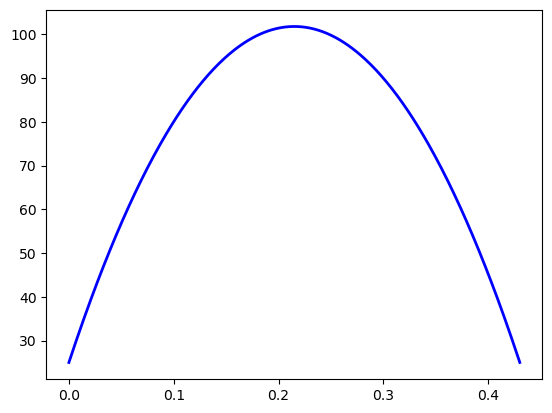

In [184]:
x_np = x.cpu().numpy()
Tw_np = Tw_sol.cpu().numpy()
plt.plot(x_np, Tw_np, 'b-', lw=2, label='Numerical (FDM + NR)')